In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from math import pi
#from Shape_Visualisation import draw_shape
%matplotlib inline

In [3]:
df=pd.read_csv("urop.csv")


# extract healthy echo data
df = df.drop(["IDshort",'SERNO','HistoCode'], 1)
mask=df["Cardiac_Category (0=good; 1=poor)"]==0
healthy_df=df[mask]
echo=healthy_df.iloc[:,19:55]

# fill in missing data
for col in echo.columns:
    echo[col].fillna(echo[col].mean(),inplace=True)

    
# data that form part of cardiac geometry    
left_ventricle=echo.iloc[:,1:8]
aorta=echo.iloc[:,8:9]
left_atrium=echo.iloc[:,9:10]
sinus=echo.iloc[:,-4:-2]

In [4]:
x_m=np.array(left_ventricle.mean())

rows=np.array([])
for i in range(len(left_ventricle)):
    x=left_ventricle.iloc[i:i+1,:]
    rows=np.append(rows,x)
rows_2d=rows.reshape(42,7)
rows_2d[0]

array([0.7, 0.9, 4. , 2.7, 0.6, 1.1, 2. ])

In [105]:
class Vector():
    def __init__(self,a):
        septum_d,septum_s=a[0],a[1]
        dim_d,dim_s=a[2],a[3]
        wall_d,wall_s=a[4],a[5]
        # Estimate shape using  parametric eqn of ellipse
        # x = u + a cos(t) ; y = v + b sin(t)

        u=0         #x-position of the center
        v=0         #y-position of the center
        a=4         #radius on the x-axis
        b=dim_d/2   #radius on the y-axis
        indices=[]

        t_all= np.linspace(0, 2*pi, 50)
        x_all=(u+a*np.cos(t_all))[::-1]
        y_all=(v+b*np.sin(t_all))[::-1]

        #plt.plot(x_all,y_all)


        #remove x,y coordinates where y< (dim_s/2)

        for i,(x,y) in enumerate(zip(x_all,y_all)):
            if y<=dim_s/2:
                indices+=[i]


        x=np.delete(x_all,indices)
        y=np.delete(y_all,indices)

        y_s=y + septum_d
        y_w= -y - wall_d


        # Split the ellipse into 2 (left and right)
        self.x_left=x[:np.argmax(y)+1]
        self.y_left=y[:np.argmax(y)+1]

        ys_left=y_s[:np.argmax(y_s)+1]
        xs_left=x[:np.argmax(y_s)+1]
        yw_left=y_w[:np.argmin(y_w)+1]
        xw_left=xs_left

        self.x_right=x[np.argmax(y_s):]
        self.y_right=y[np.argmax(y_s):]
        
    def get_vectors(self):
        
        return self.x_left, self.y_left, self.x_right, self.y_right

    def get_length(self):
        return len(self.x_left), len(self.x_right)
        

In [106]:
class Vectorise:
    
    def __init__(self,rows_2d):
        self.list_a , self.list_b = [], []
        self.rows_2d = rows_2d
        self.x_left , self.x_right , self.x_more= np.array([]), np.array([]) , np.array([])
        self.y_left , self.y_right , self.y_more= np.array([]), np.array([]) , np.array([])
        self.XY_full = np.array([])
        
        # create list of lengths of x_left and x_right
        for row in rows_2d:
            a=Vector(row)
            A,B=a.get_length()
            self.list_a.append(A)
            self.list_b.append(B)
        
        
        self.a_min= min(self.list_a)
        self.b_min= min(self.list_b)
        self.total_min = self.a_min + self.b_min
        
    def full_vectors(self):

        for row in self.rows_2d:
            a=Vector(row)
            x_left,y_left,x_right,y_right=a.get_vectors()

            idx_l,idx_r=[],[]
            if len(x_left)>self.a_min:
                idx_l+=range(self.a_min,len(x_left))

            if len(x_right)>self.b_min:
                idx_r+=range(self.b_min,len(x_right))
            
            # remove coordinates of some vectors so that all vectors have the same dimension
            self.x_left = np.delete(x_left,idx_l,axis=None)
            self.y_left = np.delete(y_left,idx_l,axis=None)

            self.x_right= np.delete(x_right,idx_r,axis=None)
            self.y_right= np.delete(y_right,idx_r,axis=None)    

            # convert vectors into the form of [x1,y1,x2,y2,......]       
            XY_left =np.array([])
            for i in range(len(self.x_left)):
                xy=np.concatenate(([self.x_left[i]],[self.y_left[i]]),axis=None)
                XY_left=np.append(XY_left,xy)


            XY_right =np.array([])
            for i in range(len(self.x_left)):
                xy=np.concatenate(([self.x_right[i]],[self.y_right[i]]),axis=None)
                XY_right=np.append(XY_right,xy)


            XY=np.concatenate((XY_left,XY_right),axis=None)
            self.x_more=np.linspace(XY[-2],6,10)
            self.y_more=np.linspace(XY[-1],XY[-1],10)

            XY_more =np.array([])
            
            for i in range(len(self.x_more)):
                xy=np.concatenate(([self.x_more[i]],[self.y_more[i]]),axis=None)
                XY_more=np.append(XY_more,xy)


            XY=np.concatenate((XY,XY_more))
            self.XY_full= np.concatenate((self.XY_full,XY))

        # full array of vectors
        self.XY_full=self.XY_full.reshape(len(rows_2d),-1)

        return self.XY_full

    
    def dataframe(self):
        df=pd.DataFrame(self.XY_full)
        
        return df
    
    def plot(self, num):
        
        a=Vector(rows_2d[num])
        x_left,y_left,x_right,y_right=a.get_vectors()

        idx_l,idx_r=[],[]
        if len(x_left)>self.a_min:
            idx_l+=range(self.a_min,len(x_left))

        if len(x_right)>self.b_min:
            idx_r+=range(self.b_min,len(x_right))

        self.x_left = np.delete(x_left,idx_l,axis=None)
        self.y_left = np.delete(y_left,idx_l,axis=None)

        self.x_right= np.delete(x_right,idx_r,axis=None)
        self.y_right= np.delete(y_right,idx_r,axis=None)    
        
        x_coordinates = np.concatenate((self.x_left,self.x_right,self.x_more),axis=None)
        y_coordinates = np.concatenate((self.y_left,self.y_right,self.y_more),axis=None)
        
        plt.plot(x_coordinates,y_coordinates)
        

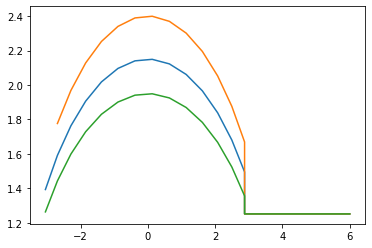

In [107]:
a=Vectorise(rows_2d)
a.full_vectors()
df=a.dataframe()
a.plot(2)
a.plot(10)
a.plot(15)